In [ ]:
# ### for colab ###

# !pip install transformers
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# source : https://iq.opengenus.org/binary-text-classification-bert/

########################################
### imports ###
########################################

# print("\n\t**** start : imports ****\n")

import seaborn as sns
from matplotlib import pyplot as plt
import random
import time
import datetime
import pandas as pd
from tqdm import tqdm
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import torch
import tensorflow as tf
from sklearn.metrics import matthews_corrcoef, roc_auc_score
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [ ]:
# initialize tqdm
tqdm.pandas()

# limit VRAM usage
#!export PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:4096

#torch.cuda.set_per_process_memory_fraction(0.4, 0)
torch.cuda.empty_cache()

In [ ]:
path_train = "../data/dataframe_train.csv"  # "/content/drive/MyDrive/dmbd/data/dataframe_train.csv"
path_val = "../data/dataframe_val.csv"  # "/content/drive/MyDrive/dmbd/data/dataframe_val.csv"
path_test = "../data/dataframe_test.csv"  # "/content/drive/MyDrive/dmbd/data/dataframe_test.csv"
path_save_plot = "../images/bert_loss_acc_auc_time_train.jpg"  # "/content/drive/MyDrive/dmbd/images/bert_loss_acc_auc_time_train.jpg"
path_scores = "./metrics_on_validation_set.csv" # "/content/drive/MyDrive/dmbd/data_mining_earnings/metrics_on_validation_set.csv"
path_save_submission = "./submission_no_na.csv" # "/content/drive/MyDrive/dmbd/data_mining_earnings/submission_no_na.csv"
epochs = 6
batch_size_train = 12
batch_size_test = 12

In [ ]:
########################################
### using GPU ###
########################################

# print("\n\t**** start : using GPU ****\n")

## tensoflow ##
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print('Tensorflow : Found GPU at: {}'.format(device_name))
else:
    raise SystemError('Tensorflow : GPU device not found')
## pytorch ##
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('PyTorch : There are %d GPU(s) available.' % torch.cuda.device_count())
    print('PyTorch : We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('PyTorch : No GPU available, using the CPU instead.')
    device = torch.device("cpu")

Tensorflow : Found GPU at: /device:GPU:0
PyTorch : There are 1 GPU(s) available.
PyTorch : We will use the GPU: Tesla T4


In [ ]:
########################################
### import datasets ###
########################################

# print("\n\t**** start : import datasets ****\n")

df = pd.read_csv(path_train)
sentences = df["text"].values
labels = df["label"].values
del df

In [ ]:
########################################
### sentences to IDs and padding ###
########################################

# print("\n\t**** start : sentences to IDs and padding ****\n")

## tokenizer ##

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

## convert sentences ##

input_ids = []
i, n = 0, len(sentences)
for i in tqdm(range(n), desc="Loading..."):
    sent = sentences[i]
    # print("{:.2f} %".format(i/n*100), end="\r")
    encoded_sent = tokenizer.encode(
        sent,
        add_special_tokens=True,
    )
    input_ids.append(encoded_sent)

## padding & Truncating to fit max length ##

MAX_LEN = 512
input_ids = list(pad_sequences(
    input_ids,
    maxlen=MAX_LEN,
    dtype="long",
    value=0,
    truncating="post",
    padding="post"
))

Loading...: 100%|██████████| 3677/3677 [00:21<00:00, 168.96it/s]


In [ ]:
########################################
### attention masks ###
########################################

# print("\n\t**** start : attention masks ****\n")

attention_masks = []
for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]
    attention_masks.append(att_mask)
# 1 when actual token, 0 when padding

In [ ]:
########################################
### train test split ###
########################################

# print("\n\t**** start : train test split ****\n")

train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(
    input_ids, labels, attention_masks,
    random_state=42, test_size=0.1)

# changing the numpy arrays into tensors for working on GPU.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size_train)

# DataLoader for our validation(test) set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':


In [ ]:
########################################
### train classifier model ###
########################################

# print("\n\t**** start : train classifier model ****\n")

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
)
# run on GPU with pytorch
model.cuda()

## print out the model ##
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())
print('The BERT model has {:} different named parameters.\n'.format(len(params)))
print('==== Embedding Layer ====\n')
for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== First Transformer ====\n')
for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== Output Layer ====\n')
for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [ ]:
########################################
### optimizer ###
########################################

# print("\n\t**** start : optimizer ****\n")

optimizer = AdamW(model.parameters(),
                  lr=2e-5,
                  eps=1e-8
                  )
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
########################################
### training ###
########################################

# print("\n\t**** start : training ****\n")

def flat_accuracy(preds, labels):
    '''
    Calculate the accuracy of our predictions vs labels
    '''
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


def flat_auc(preds, labels):
    '''
    Calculate the Area Under the ROC Curve
    More suited to unbalanced data
    '''
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    #switch last label and prediction to avoid "only one class" error.
    if sum(labels_flat) == len(labels_flat) or sum(labels_flat) == 0:
        labels_flat[-1] = (labels_flat[-1] + 1) % 2
        pred_flat[-1] = (pred_flat[-1] + 1) % 2
    return roc_auc_score(labels_flat, pred_flat)


def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
# source : huggingface `run_glue.py` at :
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

loss_values = []
accuracy_val_values = []
accuracy_train_values = []
auc_train_values = []
auc_val_values = []
time_values = []

for epoch_i in range(epochs):
    training_time = time.time()
    # ========================================
    #               Training
    # ========================================
    b_labels_epochs = np.array([])
    logits_epochs = np.empty(shape=(0, 2))
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    t0 = time.time()
    total_loss = 0
    # set model to train mod
    model.train()
    eval_loss, eval_accuracy, eval_auc = 0, 0, 0
    nb_eval_steps = 0
    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        # As we unpack the batch, we'll also copy each tensor to the GPU
        # batch  [0]: input ids ; [1]: attention masks ; [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        # clear any previously calculated gradients before performing backward pass.
        model.zero_grad()
        # Perform a forward pass
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)
        loss = outputs["loss"]
        total_loss += loss.item()
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # Clip the norm of the gradients to 1.0. Help prevent "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # Update parameters and take a step using the computed gradient.
        optimizer.step()
        # Update the learning rate.
        scheduler.step()
        # metrics for training
        logits = outputs["logits"]
        logits = logits.detach().cpu().numpy()
        logits_epochs = np.vstack((logits_epochs, logits))
        b_labels_epochs = np.array(np.hstack((b_labels_epochs,
                                              b_labels.cpu().numpy())),
                                   dtype=int)
        nb_eval_steps += 1
    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / nb_eval_steps
    # Store the loss and metrics values for plotting the learning curve.
    loss_values.append(avg_train_loss)
    accuracy_train_values.append(flat_accuracy(logits_epochs, b_labels_epochs))
    auc_train_values.append(flat_auc(logits_epochs, b_labels_epochs))
    print("")
    print("  Accuracy training: {0:.4f}".format(accuracy_train_values[-1]))
    print("  AUC training: {0:.4f}".format(auc_train_values[-1]))
    print("  Average training loss: {0:.4f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
    # ========================================
    #               Validation
    # ========================================
    print("")
    print("Running Validation...")
    t0 = time.time()
    # Put the model in evaluation mode (change dropout behaviour)
    model.eval()
    # Tracking variables
    b_labels_epochs = np.array([])
    logits_epochs = np.empty(shape=(0, 2))
    for batch in validation_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Telling the model not to compute or store gradients, saving memory and time
        with torch.no_grad():
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask)
        # The "logits" are the output values prior to applying an activation function like the softmax.
        logits = outputs["logits"]
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate the accuracy and the AUC for this batch of test sentences.
        logits_epochs = np.vstack((logits_epochs, logits))
        b_labels_epochs = np.hstack((b_labels_epochs, b_labels.cpu().numpy()))
    accuracy_val_values.append(flat_accuracy(logits_epochs, b_labels_epochs))
    auc_val_values.append(flat_auc(logits_epochs, b_labels_epochs))
    time_values.append(time.time() - training_time)
    print("  Accuracy: {0:.4f}".format(accuracy_val_values[-1]))
    print("  AUC: {0:.4f}".format(auc_val_values[-1]))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
print("")
print("Training complete!")


======== Epoch 1 / 6 ========
Training...
  Batch    40  of    276.    Elapsed: 0:00:43.
  Batch    80  of    276.    Elapsed: 0:01:30.
  Batch   120  of    276.    Elapsed: 0:02:17.
  Batch   160  of    276.    Elapsed: 0:03:05.
  Batch   200  of    276.    Elapsed: 0:03:52.
  Batch   240  of    276.    Elapsed: 0:04:40.

  Accuracy training: 0.9435
  AUC training: 0.8935
  Average training loss: 0.1892
  Training epcoh took: 0:05:23

Running Validation...
  Accuracy: 0.9728
  AUC: 0.9833
  Validation took: 0:00:14

======== Epoch 2 / 6 ========
Training...
  Batch    40  of    276.    Elapsed: 0:00:48.
  Batch    80  of    276.    Elapsed: 0:01:36.
  Batch   120  of    276.    Elapsed: 0:02:24.
  Batch   160  of    276.    Elapsed: 0:03:11.
  Batch   200  of    276.    Elapsed: 0:03:59.
  Batch   240  of    276.    Elapsed: 0:04:47.

  Accuracy training: 0.9770
  AUC training: 0.9727
  Average training loss: 0.0949
  Training epcoh took: 0:05:29

Running Validation...
  Accuracy: 0.

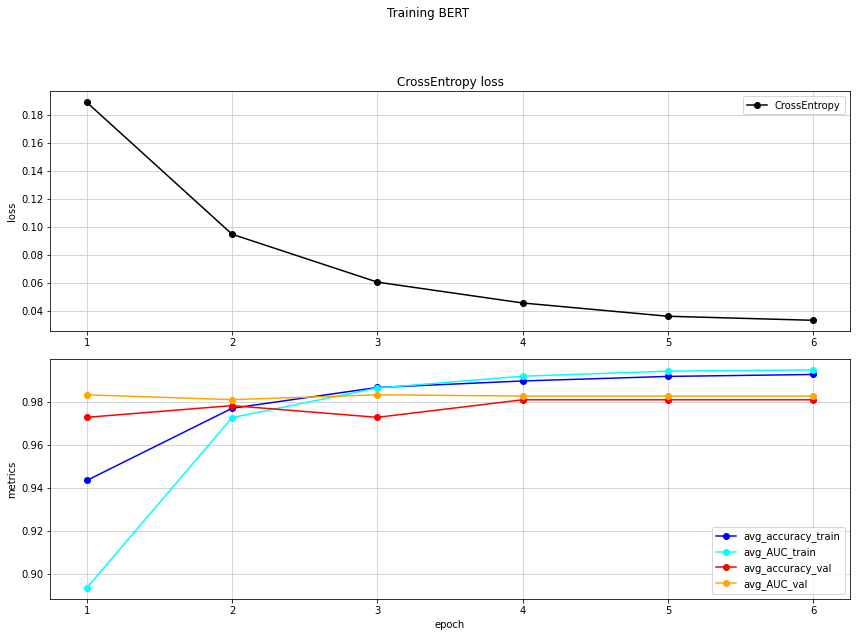

In [ ]:
########################################
### plots ###
########################################

# print("\n\t**** start : plots ****\n")

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(np.arange(1, epochs + 1),
         loss_values,
         marker='o',
         label="CrossEntropy",
         color="black")
plt.xticks(np.arange(1, epochs + 1))
# plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("CrossEntropy loss")
plt.grid(color=(0.8, 0.8, 0.8))
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(np.arange(1, epochs + 1),
         accuracy_train_values,
         marker='o',
         label="avg_accuracy_train",
         color="blue")
plt.plot(np.arange(1, epochs + 1),
         auc_train_values,
         marker='o',
         label="avg_AUC_train",
         color="cyan")
plt.plot(np.arange(1, epochs + 1),
         accuracy_val_values,
         marker='o',
         label="avg_accuracy_val",
         color="red")
plt.plot(np.arange(1, epochs + 1),
         auc_val_values,
         marker='o',
         label="avg_AUC_val",
         color="orange")

plt.xticks(np.arange(1, epochs + 1))
plt.xlabel("epoch")
plt.ylabel("metrics")
plt.grid(color=(0.8, 0.8, 0.8))
plt.legend()

plt.suptitle("Training BERT", y=1.1)
plt.tight_layout()
plt.savefig(path_save_plot)

In [ ]:
########################################
### validation set ###
########################################

# print("\n\t**** start : validation set ****\n")

## data preparation ##
# load dataset
df = pd.read_csv(path_val)
print('Number of test sentences: {:,}\n'.format(df.shape[0]))
sentences = df["text"].values
labels = df["label"].values
input_ids = []
# IDs
for sent in sentences:
    encoded_sent = tokenizer.encode(
        sent,
        add_special_tokens=True,
    )
    input_ids.append(encoded_sent)
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN,
                          dtype="long", truncating="post", padding="post")
# attention mask
attention_masks = []
for seq in input_ids:
    seq_mask = [float(i > 0) for i in seq]
    attention_masks.append(seq_mask)

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
# Create DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size_test)

## evaluate ##
print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))
# model to evaluation mode
model.eval()
# Tracking variables
predictions, true_labels = [], []
# Predict
for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask)
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    predictions.append(logits)
    true_labels.append(label_ids)
print('    DONE.')
# matthews metric
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)
print('MCC: %.4f' % mcc)
# accuracy metric
accuracy_test = np.sum(flat_predictions == flat_true_labels) / len(flat_true_labels)
print('accuracy : %.4f' % accuracy_test)
# AUC metric
auc_test = roc_auc_score(flat_predictions, flat_true_labels)
print('auc : %.4f' % auc_test)
# save metrics test
df_metrics_test = pd.DataFrame({"accuracy": [accuracy_test],
                                "AUC": [auc_test],
                                "MCC": [mcc]})
df_metrics_test.to_csv(path_scores, index=False)

Number of test sentences: 400

Predicting labels for 400 test sentences...
    DONE.
MCC: 0.9549
accuracy : 0.9850
auc : 0.9816


In [ ]:
########################################
### test set prediction ###
########################################

# print("\n\t**** start : test set ****\n")

## data preparation ##
# load dataset
df = pd.read_csv(path_test).drop("label", axis=1).dropna()
print('Number of test sentences: {:,}\n'.format(df.shape[0]))
sentences = df["text"].values
file_ids = df["id"].values
input_ids = []
# IDs
for sent in sentences:
    encoded_sent = tokenizer.encode(
        sent,
        add_special_tokens=True,
    )
    input_ids.append(encoded_sent)
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN,
                          dtype="long", truncating="post", padding="post")
# attention mask
attention_masks = []
for seq in input_ids:
    seq_mask = [float(i > 0) for i in seq]
    attention_masks.append(seq_mask)

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_file_ids = torch.tensor(file_ids)
# Create DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_file_ids)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data,
                                   sampler=prediction_sampler,
                                   batch_size=batch_size_test,
                                   shuffle=False)

## evaluate ##
print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))
# model to evaluation mode
model.eval()
# Tracking variables
predictions, file_ids = [], []
# Predict
for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_file_ids = batch
    with torch.no_grad():
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask)
    logits = outputs[0].detach().cpu().numpy()
    predictions.append(logits)
    file_ids.append(b_file_ids.to('cpu').numpy())
print('    DONE.')
# flatten predictions
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_file_ids = [item for sublist in file_ids for item in sublist]
# save predicitons
df_sub = pd.DataFrame({"id": flat_file_ids,
                       "earnings: 0 no/1 yes": flat_predictions})
df_sub.to_csv(path_save_submission, index=False)
print("predictions saved.")
### WARNING : no NaNs predictions in the file ###

Number of test sentences: 172

Predicting labels for 172 test sentences...
    DONE.
predictions saved.


In [ ]:
########################################
### save the model ###
########################################

# print("\n\t**** start : save the model ****\n")

## save ##
# import os
# output_dir = './model_save/'
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)
# print("Saving model to %s" % output_dir)
# model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
# model_to_save.save_pretrained(output_dir)
# tokenizer.save_pretrained(output_dir)

## load ##
# # Load a trained model and vocabulary that you have fine-tuned
# model = model_class.from_pretrained(output_dir)
# tokenizer = tokenizer_class.from_pretrained(output_dir)
# # Copy the model to the GPU.
# model.to(device)